In [1]:
from alpha_vantage.timeseries import TimeSeries
from pprint import pprint

In [2]:
key='8NBLCOTKI465W93V'

In [3]:
ts = TimeSeries(key=key, output_format='pandas')
data, meta_data = ts.get_intraday(symbol='MSFT',interval='1min', outputsize='full')
pprint(data.head(2))

                     1. open  2. high  3. low  4. close  5. volume
date                                                              
2021-09-29 20:00:00    284.9    284.9  284.86    284.86      549.0
2021-09-29 19:59:00    285.0    285.0  285.00    285.00      167.0


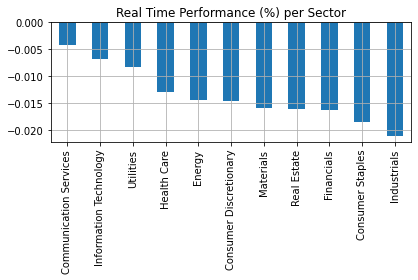

In [4]:
from alpha_vantage.sectorperformance import SectorPerformances
import matplotlib.pyplot as plt

sp = SectorPerformances(key=key, output_format='pandas')
data, meta_data = sp.get_sector()
data['Rank A: Real-Time Performance'].plot(kind='bar')
plt.title('Real Time Performance (%) per Sector')
plt.tight_layout()
plt.grid()
plt.show()

In [5]:
import requests
url = 'https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol=IBM&apikey=demo'
print(url)

https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol=IBM&apikey=demo


In [6]:
r = requests.get(url)
output = r.json()

In [7]:
print(output["Global Quote"]["05. price"])

138.9300


In [8]:
import pandas as pd
from io import StringIO
url = 'https://www.alphavantage.co/query?function=EARNINGS_CALENDAR&symbol=FVRR&horizon=3month&apikey=8NBLCOTKI465W93V'
r = requests.get(url)
content = r.text
print(str(content))

symbol,name,reportDate,fiscalDateEnding,estimate,currency
FVRR,Fiverr International Ltd,2021-10-26,2021-09-30,-0.01,USD



In [9]:
content = str(content)
f = StringIO(content)
#col_list = ["symbol"]
tbl = pd.read_csv(f, nrows=1)
#print(tbl)
#print(tbl["reportDate"][0])
print (len(tbl["reportDate"]))
if len(tbl["reportDate"]) > 0:
    dateStr = tbl["reportDate"][0]
    print(dateStr)

1
2021-10-26


In [10]:
import datetime
date = datetime.datetime.strptime(dateStr, "%Y-%m-%d").date()
d = date.strftime("%b %d")
print("Output 3:", d)

Output 3: Oct 26


In [11]:
#qtrs = [[1,3],[4,6],[7,9],[10,12]]
months = 12
qtr_len = 3
qtr_no = int(months/qtr_len)
qtrs = list()
start = 0
for i in range(qtr_no):
    qtr = list()
    start = 1 + start
    end = start + 2
    qtr.append(start)
    qtr.append(end)
    qtrs.append(qtr)
    start = end

print(qtrs)
month = 10
for o in qtrs:
    #print (o)
    if month >= o[0] and month <= o[1]:
        print(o)
        break

[[1, 3], [4, 6], [7, 9], [10, 12]]
[10, 12]


In [12]:
def get_qtrs():
    months = 12
    qtr_len = 3
    qtr_no = int(months/qtr_len)
    qtrs = list()
    start = 0
    for i in range(qtr_no):
        qtr = list()
        start = 1 + start
        end = start + 2
        qtr.append(start)
        qtr.append(end)
        qtrs.append(qtr)
        start = end
    return qtrs

In [13]:
def get_qtr_range(month, qtrs):
    #print(month)
    for o in qtrs:
        if month >= o[0] and month <= o[1]:
            return o

In [14]:
def get_stock_earningDate_detail(stock):
    url = 'https://www.alphavantage.co/query?function=EARNINGS_CALENDAR&symbol=' + stock + '&horizon=3month&apikey=8NBLCOTKI465W93V'
    try:
        r = requests.get(url)
        content = r.text
        return content
    except e:
        print(e)
        return None
    return None

In [15]:
import sys
from colorama import Fore, init, Back, Style
import openpyxl
import re

path = "stocks.xlsx"
wb_obj = openpyxl.load_workbook(path.strip())
# from the active attribute 
sheet_obj = wb_obj.active
sheet_obj

<Worksheet "12-Sep-2020">

In [16]:
max_column=sheet_obj.max_column
max_row=sheet_obj.max_row
max_column, max_row

(12, 58)

In [17]:
data = sheet_obj.cell(1,2)
print(data.value)

Quantity


In [18]:
path = "stocks_csv.csv"
d = pd.read_csv(path)
d["Ticker"]

0        NIO
1        BTI
2       ABBV
3        EPD
4        ENB
       ...  
128     DGRO
129     TD6C
130     TDG0
131    PTTRX
132      NaN
Name: Ticker, Length: 133, dtype: object

In [19]:
from datetime import datetime
qtrs = get_qtrs()
print(qtrs)
month = datetime.now().month
year = datetime.now().year
print(month, year)
qtr = get_qtr_range(month, qtrs)
qtr

[[1, 3], [4, 6], [7, 9], [10, 12]]
10 2021


[10, 12]

In [21]:
import math
months = ["0", "JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]
print(months[qtr[0]], months[qtr[1]])
cell = months[qtr[0]]+"-"+months[qtr[1]]+" "+ str(year)
#cell = months[7]+"-"+months[9]+" "+ str(year)
print(cell)
if cell not in d:
    d[cell] = None
    d.to_csv(path, index=False)
print(d[cell][3])
#if math.isnan(d[cell][3]):
#    print("Hello")

for index, value in enumerate(d[cell]):
    #print(index, value)
    #print(type(value))
    if type(value) is str:
        print(value)

OCT DEC
OCT-DEC 2021
None


In [22]:
def get_dateStr(dateStr):
    date = datetime.strptime(dateStr, "%Y-%m-%d").date()
    month = date.month
    dStr = date.strftime("%d-%b")
    return month, dStr

In [23]:
def get_month(dateStr):
    date = datetime.strptime(dateStr, "%Y-%m-%d").date()
    month = date.month
    #print(month)
    return month

In [24]:
def is_currentQtr(month):
    qtrs = get_qtrs()
    currMonth = datetime.now().month
    qtr = get_qtr_range(currMonth, qtrs)
    earningQtr = get_qtr_range(month, qtrs)
    if qtr == earningQtr:
        return True
    return False

In [25]:
status = is_currentQtr(7)
print(status)

False


In [41]:
from datetime import timedelta
print(d[cell][0])
content = d[cell][0]
if "(" not in content:
    print(True)
    #data = content.split(" ")
    #dateStr = (data[0].strip() + "-" + str(year))
    dateStr = (content.strip() + "-" + str(year))
    print(dateStr)
    date = datetime.strptime(dateStr, "%d-%b-%Y").date()
    nextDate = date + timedelta(days=1)
    print(str(date), str(nextDate))
    date = str(date)
    nextDate = str(nextDate)
    #month = date.month
    #dStr = date.strftime("%Y-%m-%d")
    #nStr = nextDate.strftime("%Y-%m-%d")
    #print(dStr)
    #return month, dStr



nan


TypeError: argument of type 'numpy.float64' is not iterable

In [27]:
url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=NIO&apikey=8NBLCOTKI465W93V"
r = requests.get(url)
output = r.json()

#curr = output.get("Time Series (Daily)").get('2021-04-30').get("5. adjusted close")
#prev = output.get("Time Series (Daily)").get('2021-04-29').get("5. adjusted close")
curr = output.get("Time Series (Daily)").get(nextDate).get("5. adjusted close")
prev = output.get("Time Series (Daily)").get(date).get("5. adjusted close")
print(curr, prev)
diff = float(curr) - float(prev)
print(diff)
if (diff > 0):
    print("UP")
elif (diff < 0):
    print(" - DN" + " (" + curr + ")")
else:
    print("NC")

NameError: name 'nextDate' is not defined

In [28]:
from datetime import datetime
from datetime import timedelta
import dateutil

def is_earningReport(title, earningDate, newsDate):
    #print(earningDate, newsDate)
    temp = earningDate
    if newsDate != temp:
        temp = temp + timedelta(days=1)
        if newsDate != temp:
            temp = earningDate
            temp = temp + timedelta(days=-1)
            if newsDate != temp:
                return False
    
    words1 = ["Announces", "Reports", "Releases", "Increase", "Raises"]
    words2 = ["Earnings", "Results", "Billable", "Revenue", "Revenues", "Income", "Letter"]
    if any(word in title for word in words1) and any(word in title for word in words2):
        #print(True)
        return True
    return False

In [29]:
def get_newsMarketTime(hour):
    if (hour > 12):
        return "AH"
    else:
        return "PM"

In [30]:
def get_newsDate(l):
    #print(l)
    interval = l.split(" ")
    num = interval[0]
    date = datetime.now()
    newsDate = None
    #print(date)
    if num == "yesterday":
        newsDate = date + timedelta(days=-1)
        newsDate = newsDate + timedelta(hours=-12.30) #For US time
    elif interval[1] == "days":
        newsDate = date + timedelta(days=-int(interval[0]))
        newsDate = newsDate + timedelta(hours=-12.30) #For US time
        #print(newsDate)
    elif interval[1] == "hours":
        newsDate = date + timedelta(hours=-int(interval[0]))
        newsDate = newsDate + timedelta(hours=-12.30) #For US time
        #print(newsDate)
    elif interval[1] == "months":
        a_month = dateutil.relativedelta.relativedelta(months=int(interval[0]))
        newsDate = date - a_month
    else:
        newsDate = date
        newsDate = newsDate + timedelta(hours=-9.30) #For US Eastern time
        #print(newsDate)
    return newsDate

In [31]:
def get_cell(d):
    qtrs = get_qtrs()
    #print(qtrs)
    month = datetime.now().month
    year = datetime.now().year
    #print(month, year)
    qtr = get_qtr_range(month, qtrs)
    #print(qtr)

    months = ["0", "JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]
    #print(months[qtr[0]], months[qtr[1]])
    cell = months[qtr[0]]+"-"+months[qtr[1]]+" "+ str(year)
    
    if cell not in d:
        d[cell] = None
        d.to_csv(path, index=False)
    return cell

In [32]:
import time
from selenium import webdriver
from bs4 import BeautifulSoup

def store_earning_news(earningDateStr, stock):
    # Web scrapper for infinite scrolling page 
    url = "https://finance.yahoo.com/quote/" + stock + "/press-releases?p=" + stock
    
    driver = webdriver.Chrome()
    driver.get(url)
    time.sleep(2)  # Allow 2 seconds for the web page to open
    scroll_pause_time = 2 
    screen_height = driver.execute_script("return window.screen.height;")   # get the screen height of the web

    i = 1
   
    SCROLL_PAUSE_TIME = 0.5
    last_height = driver.execute_script("return document.body.scrollHeight")
    while True:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(SCROLL_PAUSE_TIME)
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

    ##### Extract Article Titles #####

    earningDate = datetime.strptime(earningDateStr, '%Y-%m-%d')
    
    news_list = list()
    soup = BeautifulSoup(driver.page_source, "html.parser")

    for t in soup.find_all(class_="Cf"):
        #print(t)
        news = dict()
        a_tag = t.find("a", class_="Fw(b)", href=True)
        #a_tag = t.find("u", class_="StretchedBox")
        if a_tag:
            #print(a_tag)
            text = a_tag.text
            news["Title"] = text
            news["Link"] = "https://finance.yahoo.com" + a_tag["href"]
            news["Provider"] = None
            news["Date"] = None
            news["Content"] = None
        
            provider = t.find("div", class_="C(#959595)")
            if provider:
                c = provider.text
                ctx = (c.encode("ascii", "replace").decode())
                l = ctx.split("?")
                news["Provider"] = l[0]
                news["Date"] = str(get_newsDate(l[1]))
            else:
                continue
        
            p_content = t.find("p", class_="Fz(14px)")
            if p_content:
                c = p_content.text
                news["Content"] = c
        
            newsDateArr = news["Date"].split(" ")
            newsDateStr = newsDateArr[0]
            newsDate = datetime.strptime(newsDateStr, '%Y-%m-%d')
            if not is_earningReport(news["Title"], earningDate, newsDate):
                continue
            else:
                news_list.append(news)
                break
    if(len(news_list) == 0):
        driver.quit()
        return False, None, None

    filename = None
    newsDateStr = None
    try:
        for news in news_list:
            print(news["Link"])
            newsDateArr = news["Date"].split(" ")
            newsTime = newsDateArr[1].replace(":", "-")
            newsDateStr = newsDateArr[0]
            #filename = stock + "-" + earningDateStr + "_" + newsTime + ".txt"
            filename = stock + "-" + newsDateStr + "_" + newsTime + ".txt"
            path = "./unsup/"+filename
            url = news["Link"]
            driver.get(url)
            time.sleep(5)
    
            soup = BeautifulSoup(driver.page_source, "html.parser")
    
            content = soup.find("div", class_="caas-body")
    
            with open(path, 'x', encoding = 'utf-8') as f:
                if content:
                    #text = content.text
                    text = (" ".join(content.strings))
    
                    text = re.sub(r'Forward-Looking Statements.*|Forward Looking Statements.*',"",text)
                    #print(text)
                    if "Title" in news:
                        f.write(news["Title"])
                        f.write("\n")
                    f.write(text)
                else:
                    if "Title" in news:
                        f.write(news["Title"])
                        f.write("\n")
                    f.write(news["Content"])
            break
    except Exception as e:
        print(e)
        driver.quit()
        return False, None, None
                
    driver.quit()
    return True, filename, newsDateStr

In [33]:
from datetime import date
import glob
import holidays

def get_earningDate_quote(content, stock):
    #print(content,stock)
    if type(content) is not str:
        return None
    
    if content and "(" not in content:
        year = datetime.now().year
        dateStr = (content.strip() + "-" + str(year))
        #print(dateStr)
        try:
            ed = datetime.strptime(dateStr, "%d-%b-%Y").date()
        except:
            ed = datetime.strptime(dateStr, "%d %b-%Y").date()
        
        #print(str(ed))
        
        currDate = date.today()
        #print(currDate)
        
        if(ed>currDate):
            print("Earning for stock {} will be released later on {}".format(stock, str(ed)))
            return None
        
        #filename = "./unsup/EPD-2021-05-03*"
        filename = "./unsup/" + stock + "-" + str(ed) + "*"

        names = glob.glob(filename)
        #print(len(names))
        quote = None
        if(len(names) > 0):
            print("Earning report for stock {} on date {} exists".format(stock, str(ed)))

            for name in glob.glob(filename):
                #print(name)
                nArr = name.split("_")
                hour = (int(nArr[1].split("-")[0]))
                break
        else:
            print("Earning report for stock {} on date {} does not exist, trying to fetch it".format(stock, str(ed)))
            res, name, newsDateStr = store_earning_news(str(ed), stock)
            print("Earning report for stock {} fetching status {}, filename {}".format(stock, res, name))
            if not res or not name:
                cd = currDate + timedelta(hours=-9.30)
                #print(str(cd))
                if(ed < cd):
                    month, quote = get_dateStr(str(cd))
                    print("Updating new earning date {} for stock {}".format(quote, stock))
                    return quote
                return None
            print("Earning report for stock {} on date {} fetched, filename {}".format(stock, newsDateStr, name))
            nArr = name.split("_")
            hour = (int(nArr[1].split("-")[0]))
        
            newsDate = datetime.strptime(newsDateStr, "%Y-%m-%d").date()
            
            if (newsDate != ed):
                ed = newsDate
                print("New Earning Date {}".format(str(ed)))
        
        month, quote = get_dateStr(str(ed))
        
        newsHour = get_newsMarketTime(hour)
        print("Earning released for stock {} {}".format(stock, newsHour))
        
        us_holidays = holidays.UnitedStates(years=year)
        if newsHour == "AH":
            nextDate = ed + timedelta(days=1)
        else:
            nextDate = ed + timedelta(days=-1)
            
        while True:
            weekno = nextDate.weekday()         
            if str(nextDate) in us_holidays:
                if newsHour == "AH":
                    nextDate = nextDate + timedelta(days=1)
                else:
                    nextDate = nextDate + timedelta(days=-1)
                continue
            elif weekno >= 5:
                if newsHour == "AH":
                    nextDate = nextDate + timedelta(days=1)
                else:
                    nextDate = nextDate + timedelta(days=-1)
                continue
            else:
                break
        
        print("Get price diff for stock {} from date {} and date {}".format(stock, str(ed), str(nextDate)))
        
        ed = str(ed)
        nextDate = str(nextDate)
        
        retry = 0
        output = None
        #quote = None
        while(retry < 2):
            try:
                url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol="+stock+"&apikey=8NBLCOTKI465W93V"
                r = requests.get(url)
                output = r.json()
                break
            except e:
                print(e)
                retry = retry + 1
                time.sleep(5)
        if not output:
            return quote
        
        curr = output.get("Time Series (Daily)")
        if curr is None:
            return quote
        curr = curr.get(nextDate)
        if curr is None:
            return quote
        curr = curr.get("5. adjusted close")
        if curr is None:
            return quote
        
        prev = output.get("Time Series (Daily)")
        if prev is None:
            return quote
        prev = prev.get(ed)
        if prev is None:
            return quote
        prev = prev.get("5. adjusted close")
        if prev is None:
            return quote
        
        #print(curr, prev)
        if not quote:
            return quote
        
        if newsHour == "AH":
            diff = float(curr) - float(prev)
        else:
            diff = float(prev) - float(curr)
        #print(diff)
        if (diff > 0):
            if newsHour == "AH":
                quote = quote + (" - UP" + " (" + curr + ")")
            else:
                quote = quote + (" - UP" + " (" + prev + ")")
        elif (diff < 0):
            if newsHour == "AH":
                quote = quote + (" - DN" + " (" + curr + ")")
            else:
                quote = quote + (" - DN" + " (" + prev + ")")
        else:
            if newsHour == "AH":
                quote = quote + (" - NC" + " (" + curr + ")")
            else:
                quote = quote + (" - DN" + " (" + prev + ")")
        #print(quote)
        return (quote)
    
    return None

In [34]:
path = "stocks_csv.csv"
d = pd.read_csv(path)
quote = get_earningDate_quote(d[cell][75], d["Ticker"][75])
print(quote)

None


In [35]:
import time

def update_stock_earningDate(d, path, phase=1, updateAll=True):
    RETRY_COUNT = 3
    others = ["SCHB", "SCHD", "SCHA", "SRET", "SCHK", "DGRO", "DBEU", "TD6C", "TDG0", "PTTRX"]

    retry = 0
    status = True
    #pending_stocks = []
    
    stocks = d["Ticker"]
    #print(stocks)
    if(len(stocks) == 0):
        return True
    
    cell = get_cell(d)
    if not cell:
        return True
    
    for index, stock in enumerate(stocks):
        retry = 0
        earningDate = d[cell][index]
        
        if phase==2:
            if type(earningDate) is not str:
                #print("Earning date for stock {} not available".format(stock))
                continue
            quote = get_earningDate_quote(earningDate, stock)
            if quote is not None:
                print("Update Stock {} with quote {}".format(stock, quote))
                d.loc[index, cell] = (quote)
                d.to_csv(path, index=False)
            else:
                if "(" in earningDate:
                    print("Quote for stock {} on earning date {} already generated".format(stock, earningDate))
                else:
                    print("Quote for stock {} on earning date {} not generated yet".format(stock, earningDate))
            continue
        
        if phase==1:
            if type(earningDate) is str and not updateAll:
                continue
                        
            if type(earningDate) is str:
                if "(" in earningDate:
                    continue
        
        if stock in others:
            #print(stock, None)
            continue
        if type(stock) is not str:
            continue
        while(retry <= RETRY_COUNT):
            content = get_stock_earningDate_detail(stock)
            if content:
                content = str(content)
                f = StringIO(content)
                tbl = pd.read_csv(f, nrows=1)
                if "reportDate" in tbl and len(tbl["reportDate"]) > 0:
                    dateStr = tbl["reportDate"][0]
                    month, dateStr = get_dateStr(dateStr)
                    status1 = is_currentQtr(month)
                    print(stock, month, dateStr, status1)
                    if not status1:
                        #print(stock,dateStr)
                        break
                    d.loc[index, cell] = str(dateStr)
                    d.to_csv(path, index=False)
                    time.sleep(5)
                    break
                elif "reportDate" not in tbl:
                    retry = retry + 1
                    if(retry > RETRY_COUNT):
                        print(stock, None)
                        #pending_stocks.append(stock)
                        status = False
                    time.sleep(5)
                    continue
                else:
                    print(stock, None)
                    #pending_stocks.append(stock)
                    status = False
                    time.sleep(5)
                    break
    return status

In [36]:
status = False
retry = 0
path = "stocks_csv.csv"
d = pd.read_csv(path)

while(retry < 2):
    if retry == 0:
        status = update_stock_earningDate(d, path, 1, True)
    else:
        status = update_stock_earningDate(d, path, 1, False)
    print(status, retry)
    if(status):
        break
    else:
        retry = retry + 1

print(d[cell])

BTI None
NKE 9 23-Sep True
SFIX 9 21-Sep True
ASML None
RIO None
CPNG None
MPNGF None
NEE 10 19-Oct False
ACB 9 20-Sep True
ADBE None
FDX 9 21-Sep True
GOOG None
BP None
False 0
BTI None
ASML None
RIO None
CPNG None
MPNGF None
NEE 10 19-Oct False
GOOG None
BP None
False 1
0      11-Aug - DN (42.47)
1                      NaN
2      30-Jul - DN (116.3)
3      28-Jul - DN (23.24)
4      30-Jul - DN (39.35)
              ...         
128                    NaN
129                    NaN
130                    NaN
131                    NaN
132                    NaN
Name: JUL-SEP 2021, Length: 133, dtype: object


In [36]:
path = "stocks_csv.csv"
d = pd.read_csv(path)

status = update_stock_earningDate(d, path, 2)
print(status)

True


In [37]:
def get_earningDates(d, when):
    dt = datetime.today()
    stocks = d["Ticker"]
    
    cell = get_cell(d)
    if not cell:
        return None
    
    if(when == "WK"):
        start = dt - timedelta(days=dt.weekday())
        end = start + timedelta(days=6)
    elif (when == "TD"):
        start = dt
        end = start
    elif (when == "TM"):
        start = dt + timedelta(days=1)
        end = start
    elif (when == "YT"):
        start = dt - timedelta(days=1)
        end = start
    else:
        return None

    start = datetime.date(start)
    end = datetime.date(end)
    #print(start)
    #print(end)

    year = dt.year

    result = []
    for index, stock in enumerate(stocks):
        eStr = d[cell][index]
        combo = []
        
        if type(eStr) is not str:
            continue
            
        if "(" in eStr:
            eStr = eStr.split("-")
            #print(eStr)
            dateStr = (eStr[0].strip() + "-" + eStr[1].strip() + "-" + str(year))
        else:
            dateStr = (eStr.strip() + "-" + str(year))

        #print(dateStr)
        try:
            ed = datetime.strptime(dateStr, "%d-%b-%Y").date()
        except:
            ed = datetime.strptime(dateStr, "%d %b-%Y").date()
        #print(ed)

        if ed >= start and ed <= end:
            #print(stock, start, end, ed, True)
            combo.append(stock)
            combo.append(dateStr)
            result.append(combo)
            
    return result

In [38]:
stocks = get_earningDates(d, "WK")
print(stocks, "\n", len(stocks))

[] 
 0


In [ ]:
import re
import time
from selenium import webdriver
from bs4 import BeautifulSoup
import spacy

#nlp = spacy.load("en_core_web_trf")

url = "https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500266.html"
print(url)

driver = webdriver.Chrome()

driver.get(url)
time.sleep(2)

soup = BeautifulSoup(driver.page_source, "html.parser")
    
content = soup.find("div", class_="caas-body")
#print(content)

if content:
    #print(content.get_text())
    #filename = "PANW-2021-05-20_16-52-59.518356.txt"
    #path = "./unsupnew/"+filename
    output = (" ".join(content.strings))
    
    output = re.sub(r'Forward-Looking Statements.*|Forward Looking Statements.*',"",output)
    
    print(output)
    
    #with open(path, 'x', encoding = 'utf-8') as f:
    #    f.write(output)
    #soup = BeautifulSoup(content, "html.parser")
    #soup.get_text(separator="\n")
    #print(content.text)
    #doc = nlp(output)
    #sentences = [str(sent).strip() for sent in doc.sents]
    #print(len(sentences))
    #print(sentences)
    
    #for line in sentences:
    #    print("****** {}".format(line))
        
driver.quit()

In [85]:
import os
import re
import time
from selenium import webdriver
from bs4 import BeautifulSoup
import spacy

files_link = [
              "https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500266.html",
              "https://finance.yahoo.com/news/applied-materials-announces-second-quarter-200100432.html",
              "https://finance.yahoo.com/news/arista-networks-inc-reports-first-200500732.html",
              "https://finance.yahoo.com/news/appian-announces-first-quarter-2021-200100501.html",
              "https://finance.yahoo.com/news/alibaba-group-announces-march-quarter-112200701.html",
              "https://finance.yahoo.com/news/bristol-myers-squibb-reports-first-105900221.html",
              "https://finance.yahoo.com/news/beyond-meat-reports-first-quarter-200500876.html",
              "https://finance.yahoo.com/news/casper-reports-first-quarter-2021-103000149.html",
              "https://finance.yahoo.com/news/walt-disney-company-reports-second-200500011.html",
              "https://finance.yahoo.com/news/draftkings-reports-first-quarter-2021-110000293.html",
              "https://finance.yahoo.com/news/enbridge-reports-strong-first-quarter-110000848.html",
              "https://finance.yahoo.com/news/enterprise-reports-first-quarter-2021-100000525.html",
              "https://finance.yahoo.com/news/etsy-inc-reports-first-quarter-200500590.html",
              "https://finance.yahoo.com/news/exp-world-holdings-reports-record-123000146.html",
              "https://finance.yahoo.com/news/fulgent-genetics-reports-record-first-200500258.html",
              "https://finance.yahoo.com/news/farfetch-announces-first-quarter-2021-200600856.html",
              "https://finance.yahoo.com/news/fiverr-announces-first-quarter-2021-050000648.html",
              "https://finance.yahoo.com/news/hubspot-reports-q1-2021-results-201000012.html",
              "https://finance.yahoo.com/news/havertys-reports-first-quarter-2021-204000308.html",
              "https://finance.yahoo.com/news/horizon-therapeutics-plc-reports-first-110000158.html",
              "https://finance.yahoo.com/news/innovative-industrial-properties-reports-first-200600167.html",
              "https://finance.yahoo.com/news/inmode-reports-first-quarter-2021-111500734.html",
              "https://finance.yahoo.com/news/jd-com-announces-first-quarter-105300974.html",
              "https://finance.yahoo.com/news/lemonade-announces-first-quarter-2021-210000181.html",
              "https://finance.yahoo.com/news/medifast-inc-announces-first-quarter-200500463.html",
              "https://finance.yahoo.com/news/mercadolibre-inc-reports-first-quarter-213000148.html",
              "https://finance.yahoo.com/news/magnite-reports-first-quarter-2021-200500357.html",
              "https://finance.yahoo.com/news/match-group-reports-first-quarter-201100924.html",
              "https://finance.yahoo.com/news/nanox-announces-first-quarter-2021-110000907.html",
              "https://finance.yahoo.com/news/invitae-reports-103-6-million-200500995.html",
              "https://finance.yahoo.com/news/palo-alto-networks-reports-fiscal-200500317.html",
              "https://finance.yahoo.com/news/paycom-software-inc-reports-first-200500900.html",
              "https://finance.yahoo.com/news/palantir-reports-49-revenue-growth-110000817.html",
              "https://finance.yahoo.com/news/prospect-capital-releases-march-2021-203600447.html",
              "https://finance.yahoo.com/news/paypal-reports-first-quarter-2021-201600784.html",
              "https://finance.yahoo.com/news/qorvo-announces-fiscal-2021-fourth-200000135.html",
              "https://finance.yahoo.com/news/quantumscape-announces-first-quarter-2021-201500516.html",
              "https://finance.yahoo.com/news/repligen-reports-first-quarter-2021-113000798.html",
              "https://finance.yahoo.com/news/ringcentral-announces-first-quarter-2021-200600324.html",
              "https://finance.yahoo.com/news/roku-releases-first-quarter-2021-200300047.html",
              "https://finance.yahoo.com/news/revolve-group-announces-first-quarter-200500204.html",
              "https://finance.yahoo.com/news/square-inc-announces-first-quarter-200600101.html",
              "https://finance.yahoo.com/news/trade-desk-reports-first-quarter-123000864.html",
              "https://finance.yahoo.com/news/twilio-announces-first-quarter-2021-201000982.html",
              "https://finance.yahoo.com/news/uber-announces-results-first-quarter-200500302.html",
              "https://finance.yahoo.com/news/vir-biotechnology-provides-corporate-reports-200500093.html",
              "https://finance.yahoo.com/news/walker-dunlop-reports-20-growth-100000820.html",
              "https://finance.yahoo.com/news/wix-reports-first-quarter-2021-050000836.html",
              "https://finance.yahoo.com/news/ww-announces-first-quarter-2021-200100511.html",
              "https://finance.yahoo.com/news/zynga-announces-first-quarter-2021-200500864.html",
             ]

skip_list = ["AAPL", "ABBV", "CMG", "ASML", "ISRG", "INTC", "LRCX", 
             "KNSL", "LRN", "NIO", "MSFT", "NOW", "PACB", "PINS", "SHOP", "SIVB", "SNAP", 
             "TDOC", "TEAM", "TSLA", "V", "VRTX", "PTON"]
print(len(files_link), len(skip_list))

path = "./unsup"
newpath = "./unsupnew/"


cnt = 0
for fname in os.listdir(path):
    #print(fname)
    nf = os.path.join(newpath, fname)
    words = fname.split("-")
    stock = words[0]
    print(stock, nf, files_link[cnt])
    driver = webdriver.Chrome()    
    
    url = files_link[cnt]
    #print(url)

    driver.get(url)
    time.sleep(3)

    soup = BeautifulSoup(driver.page_source, "html.parser")
    
    content = soup.find("div", class_="caas-body")
    
    if content:
    
        output = (" ".join(content.strings))
    
        output = re.sub(r'Forward-Looking Statements.*|Forward Looking Statements.*',"",output)
    
        #print(output)
    
        with open(nf, 'x', encoding = 'utf-8') as f:
            f.write(output)
    
    driver.quit()
    cnt = cnt + 1
    
print(cnt)

50 23
ACB ./unsupnew/ACB-2021-05-13_16-52-59.518356.txt https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500266.html
AMAT ./unsupnew/AMAT-2021-05-20_13-28-46.962705.txt https://finance.yahoo.com/news/applied-materials-announces-second-quarter-200100432.html
ANET ./unsupnew/ANET-2021-05-04_16-29-14.279301.txt https://finance.yahoo.com/news/arista-networks-inc-reports-first-200500732.html
APPN ./unsupnew/APPN-2021-05-06_13-01-52.344079.txt https://finance.yahoo.com/news/appian-announces-first-quarter-2021-200100501.html
BABA ./unsupnew/BABA-2021-05-13_07-54-38.989614.txt https://finance.yahoo.com/news/alibaba-group-announces-march-quarter-112200701.html
BMY ./unsupnew/BMY-2021-04-29_14-18-33.950906.txt https://finance.yahoo.com/news/bristol-myers-squibb-reports-first-105900221.html
BYND ./unsupnew/BYND-2021-05-06_13-06-00.598192.txt https://finance.yahoo.com/news/beyond-meat-reports-first-quarter-200500876.html
CSPR ./unsupnew/CSPR-2021-05-13_07-52-27.895874.txt ht

In [38]:
import pandas as pd
import os
import re
import time
from selenium import webdriver

#url = (
#    "https://raw.githubusercontent.com/pandas-dev/pandas/master/"
#    "pandas/tests/io/data/html/spam.html"
#)

#url = "https://finance.yahoo.com/quote/SFIX/analysis?p=SFIX"
#url = "https://finance.yahoo.com/quote/SFIX/profile?p=SFIX"
url = "https://finance.yahoo.com/quote/SFIX/holders?p=SFIX"
#url = "https://finance.yahoo.com/quote/SFIX/key-statistics?p=SFIX"

driver = webdriver.Chrome()

driver.get(url)
time.sleep(2)

source = driver.page_source
#print(driver.page_source)
driver.close()
#Executive_pay
#profile = pd.read_html(url)
#profile

In [39]:
profile = pd.read_html(source)
#print(len(profile), profile)
print(profile[1], profile[1].columns[0], profile[1].iloc[0,0], profile[1].iloc[1,0])
#print(profile[0],"\n")
#print(profile[0].loc[1])
#df = profile[0].loc[1]
#print(df, type(df), type(profile))
#print(df.loc["Current Qtr. (Sep 2021)"])
#print(profile[1].iloc[1,0], profile[1].columns[1], profile[1].iloc[1,1], profile[1].iloc[1,2], profile[1].iloc[1,3])
#print(df.loc["Current Qtr. *"])
#print(df["Avg. Estimate"])

                               Holder   Shares Date Reported  % Out      Value
0  Working Capital Advisors (UK) Ltd.  6139609  Jun 29, 2021  8.55%  370218422
1          Vanguard Group, Inc. (The)  6008259  Jun 29, 2021  8.37%  362298017
2         Baillie Gifford and Company  5997845  Jun 29, 2021  8.35%  361670053
3                      Morgan Stanley  4816101  Jun 29, 2021  6.71%  290410890
4                      Blackrock Inc.  4387943  Jun 29, 2021  6.11%  264592962
5     Spyglass Capital Management LLC  3642563  Jun 29, 2021  5.07%  219646548
6        Jackson Square Partners, LLC  2750753  Jun 29, 2021  3.83%  165870405
7               Shaw D.E. & Co., Inc.  2658744  Jun 29, 2021  3.70%  160322263
8              Slate Path Capital, LP  2534320  Jun 29, 2021  3.53%  152819496
9  Disciplined Growth Investors, Inc.  2461920  Jun 29, 2021  3.43%  148453776 Holder Working Capital Advisors (UK) Ltd. Vanguard Group, Inc. (The)


In [40]:
DataExtract = [
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/holders?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"HOLDERS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":1,
                            "MATCH":"SHARES HELD BY ALL INSIDER",
                            "ALIAS":"INSIDERHELDPCT",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":1,
                            "MATCH":"SHARES HELD BY INSTITUTIONS",
                            "ALIAS":"INSTHELDPCT",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":2,
                            "COLUMN":1,
                            "MATCH":"FLOAT HELD BY INSTITUTIONS",
                            "ALIAS":"INSTHELDFLTPCT",
                            "VALUE":
                            {
                                "ROW":2,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":3,
                            "COLUMN":1,
                            "MATCH":"NUMBER OF INSTITUTIONS",
                            "ALIAS":"INSTNUM",
                            "VALUE":
                            {
                                "ROW":3,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            }
        ]
    },
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/analysis?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"ANALYSIS",
            "TYPE":"FRAME"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            }
        ]
    },
    {      
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/key-statistics?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"STATS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":9
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"LEVERED FREE CASH FLOW",
                            "ALIAS":"FCF",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"TOTAL CASH",
                            "ALIAS":"CASH",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"TOTAL CASH PER SHARE",
                            "ALIAS":"CASHPERSHARE",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":2,
                            "COLUMN":0,
                            "MATCH":"TOTAL DEBT",
                            "ALIAS":"DEBT",
                            "VALUE":
                            {
                                "ROW":2,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":4,
                            "COLUMN":0,
                            "MATCH":"CURRENT RATIO",
                            "ALIAS":"CURRATIO",
                            "VALUE":
                            {
                                "ROW":4,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":6
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"RETURN ON ASSETS",
                            "ALIAS":"ROA",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":6
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"RETURN ON EQUITY",
                            "ALIAS":"ROE",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":4
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"FISCAL YEAR ENDS",
                            "ALIAS":"FISCALYEND",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":4
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"MOST RECENT QUARTER",
                            "ALIAS":"MRQ",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"FORWARD ANNUAL DIVIDEND YIELD",
                            "ALIAS":"FDIVYLD",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":3,
                            "COLUMN":0,
                            "MATCH":"TRAILING ANNUAL DIVIDEND YIELD",
                            "ALIAS":"TDIVYLD",
                            "VALUE":
                            {
                                "ROW":3,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":5,
                            "COLUMN":0,
                            "MATCH":"PAYOUT RATIO",
                            "ALIAS":"PAYOUTRATIO",
                            "VALUE":
                            {
                                "ROW":5,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":6,
                            "COLUMN":0,
                            "MATCH":"DIVIDEND DATE",
                            "ALIAS":"DIVDATE",
                            "VALUE":
                            {
                                "ROW":6,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":7,
                            "COLUMN":0,
                            "MATCH":"EX-DIVIDEND DATE",
                            "ALIAS":"EXDIVDATE",
                            "VALUE":
                            {
                                "ROW":7,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"MARKET CAP",
                            "ALIAS":"MCAP",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":5,
                            "COLUMN":0,
                            "MATCH":"PRICE/SALES",
                            "ALIAS":"PS",
                            "VALUE":
                            {
                                "ROW":5,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":5,
                            "COLUMN":0,
                            "MATCH":"50-DAY MOVING AVERAGE",
                            "ALIAS":"50DMA",
                            "VALUE":
                            {
                                "ROW":5,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":6,
                            "COLUMN":0,
                            "MATCH":"200-DAY MOVING AVERAGE",
                            "ALIAS":"200DMA",
                            "VALUE":
                            {
                                "ROW":6,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"AVG VOL (3 MONTH)",
                            "ALIAS":"AVGVOL3MONTH",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"AVG VOL (10 DAY)",
                            "ALIAS":"AVGVOL10DAY",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":9,
                            "COLUMN":0,
                            "MATCH":"SHORT % OF FLOAT",
                            "ALIAS":"SHORTPCTFLOAT",
                            "VALUE":
                            {
                                "ROW":9,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":10,
                            "COLUMN":0,
                            "MATCH":"SHORT % OF SHARES OUTSTANDING",
                            "ALIAS":"SHORTPCTOUST",
                            "VALUE":
                            {
                                "ROW":10,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            }
        ]
    }
]
print(DataExtract)

[{'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/holders?p=*ORG'}, 'TABLE': {'NAME': 'HOLDERS', 'TYPE': 'SERIES'}, 'TUPLES': [{'CONDITIONS': [{'TABLENUM': 0}], 'ACTIONS': [{'KEY': {'ROW': 0, 'COLUMN': 1, 'MATCH': 'SHARES HELD BY ALL INSIDER', 'ALIAS': 'INSIDERHELDPCT', 'VALUE': {'ROW': 0, 'COLUMN': 0}}}]}, {'CONDITIONS': [{'TABLENUM': 0}], 'ACTIONS': [{'KEY': {'ROW': 1, 'COLUMN': 1, 'MATCH': 'SHARES HELD BY INSTITUTIONS', 'ALIAS': 'INSTHELDPCT', 'VALUE': {'ROW': 1, 'COLUMN': 0}}}]}, {'CONDITIONS': [{'TABLENUM': 0}], 'ACTIONS': [{'KEY': {'ROW': 2, 'COLUMN': 1, 'MATCH': 'FLOAT HELD BY INSTITUTIONS', 'ALIAS': 'INSTHELDFLTPCT', 'VALUE': {'ROW': 2, 'COLUMN': 0}}}]}, {'CONDITIONS': [{'TABLENUM': 0}], 'ACTIONS': [{'KEY': {'ROW': 3, 'COLUMN': 1, 'MATCH': 'NUMBER OF INSTITUTIONS', 'ALIAS': 'INSTNUM', 'VALUE': {'ROW': 3, 'COLUMN': 0}}}]}]}, {'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/analysis?p=*ORG'}, 'TABLE': {'NAME': 'ANALYSIS', 'TYPE': 'FRAME'}, 'TUPLES': [{'CONDITIONS'

In [40]:
import pandas as pd
import os
import re
import time
from selenium import webdriver

def GetTables(url):
    driver = webdriver.Chrome()

    driver.get(url)
    time.sleep(2)

    source = driver.page_source
    try:
        table = pd.read_html(source)
    except:
        return None
    #print(driver.page_source)
    driver.close()
    return table

In [42]:
org = "SFIX"
data = dict()
for idx,rule in enumerate(DataExtract):
    #print(rule["SOURCE"]["URL"])
    url = rule["SOURCE"]["URL"]
    url = url.replace("*ORG", org)
    print(url)
    table = GetTables(url)
    #print(table)
    tableName = rule["TABLE"]["NAME"]
    tableType = rule["TABLE"]["TYPE"]
    print("TABLE NAME", tableName)
    data[tableName] = dict()
    #print(rule["TUPLES"])
    for tidx,tple in enumerate(rule["TUPLES"]):
        #print(tple)
        found = False
        for cidx,cnd in enumerate(tple["CONDITIONS"]):
            #print(cnd)
            if "TABLENUM" in cnd:
                print("Table Number", cnd["TABLENUM"])
                tableNum = cnd["TABLENUM"]
                if len(table) >= tableNum:
                    found = True
                    print("FOUND")
                break
        if(found):
            for aidx,act in enumerate(tple["ACTIONS"]):
                #print(act)
                if "KEY" in act:
                    if tableType == "SERIES":
                        rowKey = act["KEY"]["ROW"]
                        columnKey = act["KEY"]["COLUMN"]
                        matchRegex = act["KEY"]["MATCH"]
                        alias = act["KEY"]["ALIAS"]
                    
                        key = table[tableNum].iloc[rowKey,columnKey]
                        if(matchRegex in key.upper()):
                            valueRow = act["KEY"]["VALUE"]["ROW"]
                            valueColumn = act["KEY"]["VALUE"]["COLUMN"]
                            value = table[tableNum].iloc[valueRow,valueColumn]
                            print(rowKey, columnKey, key.upper(), valueRow, valueColumn, value)
                            data[tableName][alias] = value
                    elif tableType == "FRAME":
                        columnNum = act["KEY"]["COLUMN"]
                        matchRegex = act["KEY"]["MATCH"]
                        alias = act["KEY"]["ALIAS"]
                        keyName = act["KEY"]["NAME"]
                        column = table[tableNum].columns[columnNum]
                        
                        if keyName not in data[tableName]:
                            data[tableName][keyName] = dict()
                        
                        if(not matchRegex or (matchRegex and matchRegex in column.upper())):
                            valueRow = act["KEY"]["VALUE"]["ROW"]
                            valueColumn = act["KEY"]["VALUE"]["COLUMN"]
                            value = table[tableNum].iloc[valueRow,valueColumn]
                            print(columnNum, column.upper(), valueRow, valueColumn, value)
                            if(alias):
                                data[tableName][keyName][alias] = value
                            else:
                                data[tableName][keyName][column] = value
                            
                #rowKey = act["KEY"]["ROW"]
                #columnKey = act["KEY"]["COLUMN"]
print("FINAL DATA", data)

https://finance.yahoo.com/quote/SFIX/holders?p=SFIX
TABLE NAME HOLDERS
Table Number 0
FOUND
0 1 % OF SHARES HELD BY ALL INSIDER 0 0 3.45%
Table Number 0
FOUND
1 1 % OF SHARES HELD BY INSTITUTIONS 1 0 95.00%
Table Number 0
FOUND
2 1 % OF FLOAT HELD BY INSTITUTIONS 2 0 98.40%
Table Number 0
FOUND
3 1 NUMBER OF INSTITUTIONS HOLDING SHARES 3 0 377
https://finance.yahoo.com/quote/SFIX/analysis?p=SFIX
TABLE NAME ANALYSIS
Table Number 2
FOUND
1 10/30/2020 1 1 0.09
Table Number 2
FOUND
2 1/30/2021 1 2 -0.2
Table Number 2
FOUND
3 4/29/2021 1 3 -0.18
Table Number 2
FOUND
4 7/30/2021 1 4 0.19
Table Number 2
FOUND
1 10/30/2020 0 1 -0.2
Table Number 2
FOUND
2 1/30/2021 0 2 -0.22
Table Number 2
FOUND
3 4/29/2021 0 3 -0.27
Table Number 2
FOUND
4 7/30/2021 0 4 -0.13
Table Number 1
FOUND
1 CURRENT QTR. (OCT 2021) 1 1 572.18M
Table Number 1
FOUND
2 NEXT QTR. (JAN 2022) 1 2 584.26M
Table Number 1
FOUND
3 CURRENT YEAR (2022) 1 3 2.44B
Table Number 1
FOUND
4 NEXT YEAR (2023) 1 4 2.85B
Table Number 0
FOUND
